# Introduction to PyTorch

https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html

## Pytorch Tensors (영상 03:50 ~ 10:00)
이미 한번 다룬 내용이라 pass

## Pytorch Models (영상 10:00)

Pytorch에서 모델을 표현하는 방법에 대해서 알아본다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

![LeNet5](https://tutorials.pytorch.kr/_images/mnist.png)

그림: LeNet-5

LeNet-5는 초기 합성곱 신경망 중 하나이자 딥러닝에서 폭발적인 인기를 일으킨 요인중 하나이다. 손으로 쓴 숫자이미지(MNIST)를 읽고 이미지에 어떤 숫자가 표현되었는지 정확히 분류하기 위해 제작되었음.  

LeNet-5의 동작에 대한 설명은 다음과 같다.
- 계층 C1: 합성공 계층으로, 입력 이미지를 스캔하여 training 도중에 배웠던 feature를 찾고자 함. 그 결과, 학습한 image의 feature 각각에 대한 map을 반환함. 이는 `activation map`이라고 하고, layer S2에 의해 downsampling 된다. 
- 계층 C3: 또 다른 합성공 계층으로, 이번에는 C1의 activation map을 스캔하여 feature들의 combination을 찾고자 함. 이것 역시 공간적 `activation map`을 반환한다. 이 map은 feature combinations의 공간적 위치를 기술하며, 이는 S4에서 downsampling 된다.
- 마지막으로 fully connected layers인 F5, F6, OUTPUT은 최종 `activation map`을 가져와 십진수를 표현하는 10개의 class 중 하나로 분류하는 분류기이다.

이 simple 한 neural network를 코드로 표현해본다.

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Figure를 보면 크기가 32*32인 입력 채널 1개에서 다음 output은 크기가 28*28인 채널 6개이다. 따라서 입력 1개, output 6개, 32->28이 되기 위해 크기가 5인 커널을 사용해야한다.
        self.conv1 = nn.Conv2d(1, 6, 5) # 이는 입력 이미지 채널 1개, 6개의 output 채널, 5*5 정방 합성곱 커널을 사용한다는 의미이다.
        self.conv2 = nn.Conv2d(6, 16, 5) # 이는 입력 이미지 채널 6개, 16개의 output 채널, 5*5 정방 합성곱 커널을 사용한다는 의미이다.
            
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2)) # height랑 weight에서 pooling 사이즈 어떻게 잡을지인데, 이렇게 2*2로 둘의 크기가 같다면 2 하나만 적어도 된다.        
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        
        # 5*5크기의 맵이 16개 있는 상태에서 이를 어떻게 처리하는지 보여줌.
        # 먼저 num_flat_features이라고 하는 함수에 x를 넣는데, num_flat_features는 하나의 맵안에 있는 픽셀의 총 개수이다. 여기선 25개.
        # 그 후에 view(-1)를 적용한다. 즉, x.view(-1,25)로, x.shape는 ([num_of_map,feature의 개수]) 가 된다.
        print('Before num_flat_features:',x.shape)
        x = x.view(-1, self.num_flat_features(x))
        print('After num_flat_features:',x.shape)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # batch dimension을 제외한 모든 차원, 즉 여기선 5*5 크기의 맵을 넣음으로써, size는 (5,5)가 될 것이다.
        num_features = 1
        for s in size:
            num_features *= s # 이는 이번 예시로 보면 5*5가 되어 num_features는 25가 된다.
            
        return num_features        

이 코드에서 각각의 코드가 위의 LeNet Figure에 어떻게 대응되는지 파악할 수 있어야한다.  
위의 모델이 Pytorch model의 전형적인 구조를 보여준다.  
- torch.nn.Module을 상속받음,모듈들은 중첩(?)할 수도 있음 ,Conv2d와 Linear 레이어 classes도 torch.nn.Module에서 상속받은 것이다.
    - 상속을 받으면 nn.Module에 있는 모든 함수를 상속받아 사용 가능하다.
    - 참고1: https://stackoverflow.com/questions/72505199/why-do-we-need-to-inherit-from-nn-module-in-pytorch
    
    - 상속받을 때 super()의 의미: https://velog.io/@qw4735/Pytorch-nn.Module%EC%9D%84-%EC%83%81%EC%86%8D%EB%B0%9B%EC%9D%84-%EB%95%8C-super.init%EC%9D%84-%ED%95%98%EB%8A%94-%EC%9D%B4%EC%9C%A0
    
- 모델은 `__init__()` 이라는 함수를 가진다 - 이는 모델의 layers를 인스턴스화 하고, 모델이 필요한 어떤 데이터든 load를 한다.
- 모델은 `forward()` 함수를 가진다 - 이는 실제 계산이 이루어지는 파트이다. input은 네트워크의 layers와 다양한 functions에 전달되고 output을 return한다.
- 그 외에도 사용자는 어떤 필요한 properties나 methods를 추가하면서, 사용자만의 model classs를 다른 Python class 처럼 만들 수 있다. 

이제 모델 object를 instance로 만들어서 input 샘플과 함께 실행을 해본다.

In [3]:
net = LeNet()
print(net)

input_image = torch.rand(1, 1, 32, 32) # 32*32 black & white image
print('\nImage batch shape:')
print(input_image.shape)

output = net(input_image) # 우리가 직접적으로 forward()를 호출하지 않는다.
print('\nRaw output:')
print(output)
print(output.shape)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 1, 32, 32])
Before num_flat_features: torch.Size([1, 16, 5, 5])
After num_flat_features: torch.Size([1, 400])

Raw output:
tensor([[-0.0452, -0.0564, -0.1088, -0.0037,  0.0078, -0.0708, -0.0752,  0.0604,
          0.0597, -0.0320]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


위의 실행을 하나씩 살펴보자.

먼저, 우리는 `LeNet`클래스를 인스턴스화 하였다. 그리고 `net` object를 print 해보았다. 이는 `torch.nn.Module`의 subclass는 이것이 생성한 layers, shape, parameters를 report해준다. 이는 model에 대한 유용한 개요를 제공하여, 모델 처리 요점을 파악하고자할 떄 쓰일 수 있다.

이 이후에, 우리는 채널이 1개인 32$*$32 크기의 input을 만들었다. 보통, 우리는 image를 load하고 이를 이러한 shape의 텐서로 바꾸게 된다.  
그런데, 1채널, 32$*$32를 제외하고 1이 추가로 붙은 것을 알 수 있는데, 이것은 `batch dimension` 이라고 하는 것이다. Pytorch models는 data의 batch와 함께 작동한다는 가정을 한다. 예를들어, 우리가 16개의 image를 다룬다면, shape는 (16,1,32,32)가 될 것이다. 하지만 위의 예시에서 우리는 image를 오직 하나만 사용했기 때문에, batch가 1인 상태였고, shape는 (1,1,32,32)였던 것이다.

우리는 예측을 할 때, `net(input)`을 호출하여 예측을 하였다. `net(input)`의 output은 model이 "이 input은 어떠어떠한 숫자를 나타낸다"라고 얼마나 확신하는지 confidence를 나타낸다. `output`의 shape를 보면, 이 역시 batch dimension이 있음을 알 수 있다. output의 batch size는 input의 batch size와 크기가 항상 같아야한다. 만약 우리의 input batch가 16이였다면 output의 shape는 (16,10)이였을 것이다.

## Datasets and Dataloaders (영상 14:00 부터)

여기서는 이미 다운받아진, 접근 가능한 dataset을 사용해서 어떻게 model에 맞게 image를 transform하고 모델에 data batch를 전달하는 DataLoader를 어떻게 사용할지 볼 것이다.

먼저, 우리가 할 것은 우리의 image를 PyTorch tensor로 변환하는 것이다.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.5,0.5,0.5), (0.5,0.5,0.5) )])

위 코드에서 우리는 두가지 transformations를 명시했다.
- `transforms.ToTensor()` 는 Pillow(PIL)로 불러온 이미지를 PyTorch tensors로 변환하는 역할을 한다.
- `trnasforms.Normalize()` 는 tensor의 값을 조절하여 이들의 평균이 0이 되고, 표준편차가 0.5가 되도록 한다. 대부분 activation functions는 gradients값이 x=0 근처에서 가장 강하게 잡혀서, 데이터를 centering하는 것이 학습 속도를 빠르게 할 수 있다.

이것 이외에도 `cropping`, `centering`, `rotation`, `reflection`과 같은 다양한 transforms가 있다.

다음으로, CIFAR10 dataset의 instance를 생성해보자. 이는 32*32크기의 color image이고, 10 개의 클래스가 있다.
- 10개의 클래스: 6개의 동물 클래스(bird, cat, deer, dog, frog, horse)와 4개의 탈 것(비행기, 자동차, 배, 트럭)

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)

Files already downloaded and verified


이것은 PyTorch에서 dataset을 생성하는 예시이다. CIFAR-10같은 다운로드 가능한 dataset은 `torch.utils.data.Dataset`의 subclass이다. 파이토치에서 `Dataset` 클래스는 `torchvision.datasets.ImageFolder`말고도 TorchVision, Torchtext, TorchAudio의 다운로드 가능한 dataset을 포함한다. 

dataset을 instance화 할 때, 다음의 내용들을 언급해야한다.
- 데이터를 어디로 보낼지 filesystem path를 명시해야한다.
- 우리가 dataset을 training을 위해 사용할지 안할지, 대부분의 dataset은 training과 test subset으로 나뉜다.
- 우리가 dataset이 없을 때, 이걸 다운로드 받고 싶은지 아닌지
- 데이터에 적용하고 싶은 transformations

위와 같은 내용들을 가지고 dataset이 준비가 됬으면, 이제 `DataLoader`에 준비한 dataset을 넘길 수 있다.

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

`Dataset` subclass는 data에 대한 접근을 wrap(?)하고, 이것이 제공하는 data 타입에 특화되어있다 한다. DataLoader는 data에 대해서는 아무것도 모르고, Dataset으로부터 제공받은 input tensors를 사용자가 설정한 파라메터와 함께 batch로 organizes한다.

위의 예시에서, 사용자는 `DataLoader`가 사용자에게 4개의 이미지 batch를 train set에서부터 달라고 요청하였고, 이들의 순서는 shuffle=True를 통해서 랜덤화 하였다.

위에서 정의한 `DataLoader`가 제공하는 batch를 visualize해보자.

plane   cat   dog  frog


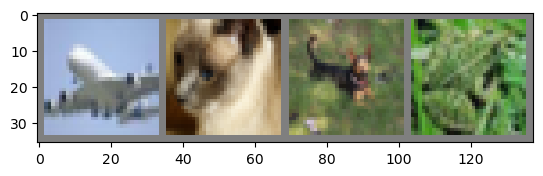

In [7]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # 지금 받는 데이터는 DataLoader에서 transforms를 적용한 상태, 먼저 transforms.Normalization을 푼다.
    npimg = img.numpy() # ToTensor를 적용했던 것을 numpy 형태로 바꾼다.
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 이미지 출력은 (너비, 높이?, 채널) 순서로 shape가 되어야 한다.
    
    
detaiter = iter(trainloader)
images, labels = next(detaiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Training Your PyTorch Model (영상 17:10 부터)

이제 여태까지 봐왔던 것들을 한번에 모아서 model을 학습하자.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

먼저, training dataset과 test dataset이 필요하다. 아래 코드를 실행하여 데이터를 준비하자.

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


DataLoader의 output을 확인해보자.

 frog truck truck  deer


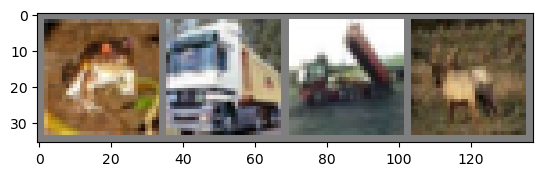

In [10]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # 지금 받는 데이터는 DataLoader에서 transforms를 적용한 상태, 먼저 transforms.Normalization을 푼다.
    npimg = img.numpy() # ToTensor를 적용했던 것을 numpy 형태로 바꾼다.
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 이미지 출력은 (너비, 높이?, 채널) 순서로 shape가 되어야 한다.
    
    
detaiter = iter(trainloader)
images, labels = next(detaiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

아래는 우리가 training할 모델이다. 아래는 `LeNet`의 변형 버전으로, 3색 image를 받아들이도록하는 모델이라 한다.

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net = Net()

마지막으로, loss function과 optimizer를 정의해야한다.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

optimizer는 학습을 이끌어낸다. 여기서 우리는 stochastic gradient descent(SGD)로 구현된 optimizer를 정의하였고, SGD는 간단한 최적화 알고리즘 중 하나이다. `net.parameters()`도 optimizer의 인자값으로 넣어줬는데, 이는 model의 학습가능한 모든 weights들의 집합이라고 보면된다. 이는 optimizer가 조절하는 값이 된다.  

마지막으로 위에서 정의한 것들을 training loop에 하나로 모아서 코드를 작성한다.

In [14]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.241
[1,  4000] loss: 1.873
[1,  6000] loss: 1.697
[1,  8000] loss: 1.572
[1, 10000] loss: 1.517
[1, 12000] loss: 1.484
[2,  2000] loss: 1.404
[2,  4000] loss: 1.367
[2,  6000] loss: 1.336
[2,  8000] loss: 1.326
[2, 10000] loss: 1.298
[2, 12000] loss: 1.299
Finished Training


하나씩 살펴보도록 하자. 

우리는 **2 training epoch**만을 설정하였다. 이는 training dataset을 2번 pass(넘긴다는 것)를 의미한다. 각 pass내부에서도 training data에 대한 iteration이 있는데, 이는 transformed된 input images와 이에 대응되는 labels의 batch를 넘기는 것을 의미한다.

Gradients를 0으로 만드는 것(line 9)가 중요한 부분이다. Gradients는 batch마다 값이 축적된다. 만야 우리가 매번 batch마다 gradients를 reset하지 않으면, 이 gradient값은 계속 쌓일 것이다. 그렇게 되면, 이는 정확하지 않은 gradient 값을 주고, 학습을 불가능하게 만들 것이다.

line 12는 모델이 각 batch에 대해서 예측하도록 하는 코드이다. line 13은 모델의 예측값(`output`)과 실제 라벨값(`label`)간의 loss를 계산한다.

line 14는 `backward()`를 사용했는데, 이는 학습에 쓰일 gradient를 계산해주는 함수이다.

line 15는 optimizer가 learning step 한번을 실행하는 것이다. 여기서 optimizer는 `backward()`에서 계산된 gradients를 가지고 손실이 줄어들 것 같은 방향으로 학습되는 weights값을 업데이트 한다.


loss는 단조롭게 감소하는데, 이는 우리의 모델 성능이 training dataset에 대해 계속 증가하고 있음을 가르킨다.

마지막으로, 모델이 실제로 `일반적인(general)` 학습을 하는지, 모델이 그저 dataset을 암기하는 것은 아닌지 체크해야한다. 이러한 현상을 **overfitting**이라고 하는데, 이는 보통 dataset이 너무 작다는 것(general learning에 충분한 데이터가 아님) 혹은 모델이 dataset의 패턴을 정확히 모델링하는데에 필요한 것보다 더 많은 학습 parameter를 가지고 있는 것을 나타낸다.

이것이 dataset을 training과 test set으로 분리해야하는 이유이다. 이 분리를 통해 model의 generality를 테스트할 수 있고, 모델이 학습하지 않은 데이터에 대해 예측을 하도록 할 수 있다.

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


위의 성능을 보면 약 50% 확률로 답을 맞춤을 알 수 있다. 이게 SOTA 성능은 아니지만, 랜덤으로 10개의 클래스 중 하나를 맞추는 10%확률보다는 낫다. 이것으로 model에서 genenral learning이 약간 일어났음을 알 수 있다.